In [50]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

***Посмотрим что можно сделать с рядом рождения девочек. Ряд относительно стационарен, поэтому попробуем применить к нему скользящую среднюю чтобы посмотреть тренд и затем экспоненциальную среднюю для предсказаний.***

In [51]:
series1 = pd.read_csv('D:/Учеба/Lern DS of Netology/Курс ML 3 Временные ряды/01_Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv')['Count']

In [52]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [53]:
ma_ser1 = moving_average(series1, 7)

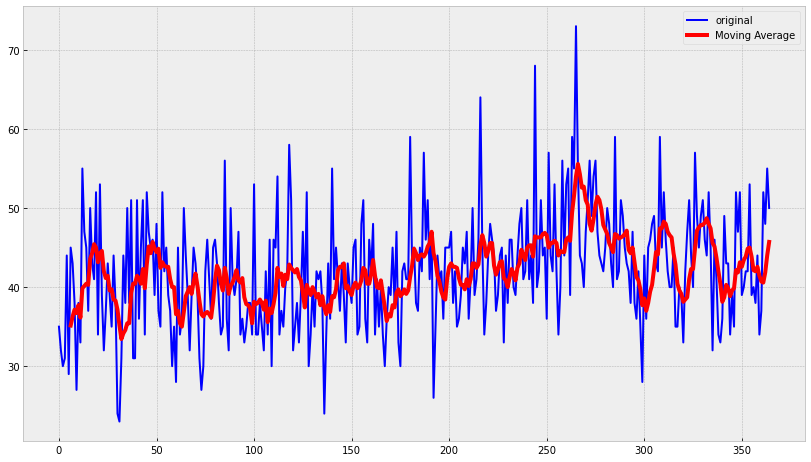

In [54]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ma_ser1, color='red', linewidth='4', label='Moving Average')
    plt.legend()

**Видим что ярко выраженного тренда нет. Поробуем экспоненциальное сглаживание**

In [55]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [56]:
ema_ser1 = exponential_moving_average(series1, 0.2)

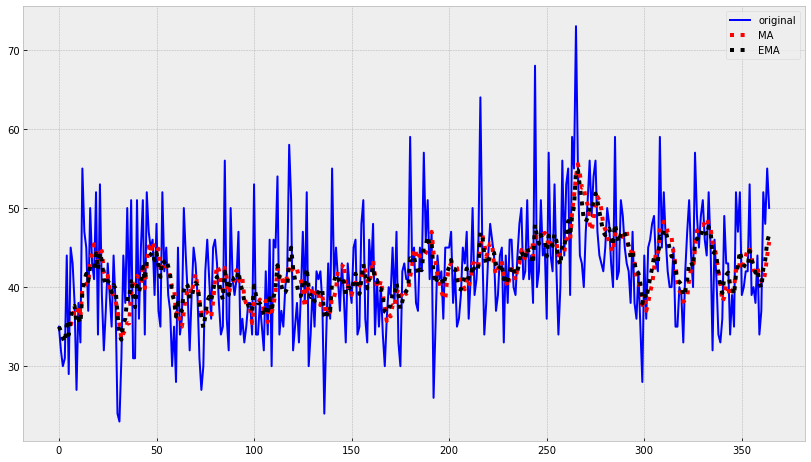

In [57]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue', label='original')
    plt.plot(ma_ser1, color='red', linestyle = ':', linewidth='4', label='MA')
    plt.plot(ema_ser1, color='black', linestyle=':', linewidth='4', label='EMA')
    plt.legend()

Попробуем использовать двойное экспоненциальное сглаживание и предсказать 10 значений

In [58]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [59]:
dema_ser1, dema_pred1 = double_ema_with_preds(series1, 0.1, 0.1, 10)

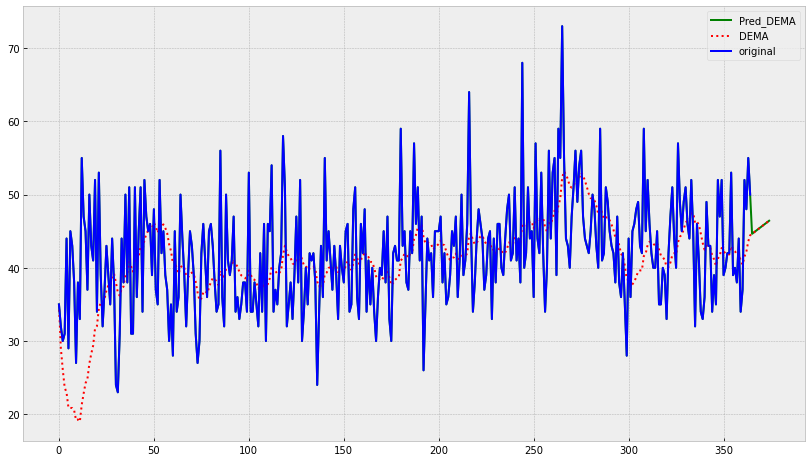

In [61]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    
    plt.plot(dema_ser1, color='green', label='Pred_DEMA')
    plt.plot(dema_pred1, color='red', linestyle=':', linewidth='2', label='DEMA')
    
    plt.plot(series1, color='blue', label='original')
    
    plt.legend()

Подберём параметры alpha и beta

In [63]:
train, test, val = series1[:210], series1[210:310], series1[310:]

In [76]:
def mse(X):
    alpha, beta = X
    result, _ = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [78]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [80]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 12515.00799219268
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.18278727e-03, -2.62269030e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.71092501, 1.        ])


In [81]:
dema_ser1, dema_pred1 = double_ema_with_preds(series1, alpha_opt, beta_opt, 10)

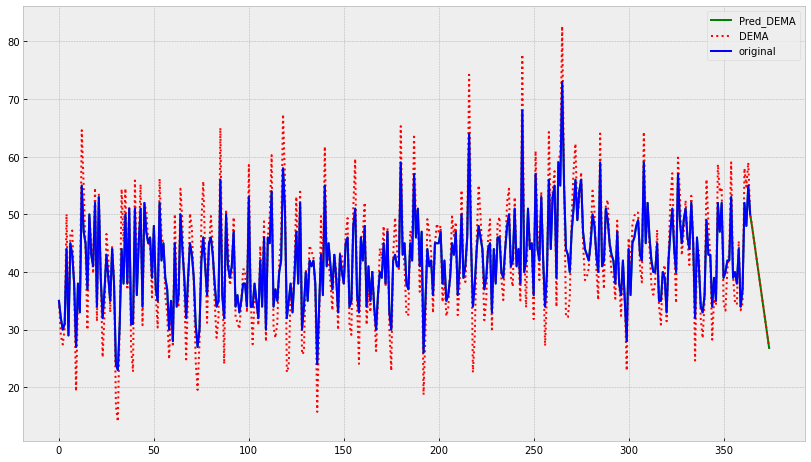

In [82]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    
    plt.plot(dema_ser1, color='green', label='Pred_DEMA')
    plt.plot(dema_pred1, color='red', linestyle=':', linewidth='2', label='DEMA')
    
    plt.plot(series1, color='blue', label='original')
    
    plt.legend()

**Двойная экспоненциальная средняя с подбором параметров показала себя хуже чем без, предполагаю что нужно подобрать более подходящий оптимизационный алгоритм**  